# <center> «Метанпромбанк»: сегментирование пользователей, склонных к оттоку
    

 

### Получение и предобработка данных

In [1]:
#устанавливаем пакет phik без вывода инмформации об установке
import os
import subprocess
subprocess.call(['pip', 'install', 'phik'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


0

In [2]:
#подключаем библиотеки, необходимые для работы
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import median
from matplotlib import pyplot as plt
from scipy import stats as st
import phik
from phik import resources, report

In [3]:
#загружаем файл
data = pd.read_csv('/datasets/bank_scrooge.csv')
#отображаем первые 5 строк для ознакомления
display(data.head(5))

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Таблица получена, в ней содержится основная информация о клиентах: пол, вораст, оценочные значения, информация о наличии продуктов, кредитных кард, а также баланс, оценочная зарплата и информация об активности и отточности клиента.

In [4]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

Форматы данных в целом соответствуют столбцам, данный пункт можно оставить без изменений. Также видим наличие пропусков в столбцах age и balance.
При изучении общей информации сразу бросается в глаза написание двух столбцов: USERID и EST_SALARY. Приведем их к общепринятому "змеиному регистру".

In [5]:
#переименовываем столбцы
data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'}, inplace=True)
#выводим названия столбцов для проверки
print(data.columns)

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')


Еще раз выведем информацию о пропусках в таблице.

In [6]:
print('Количество пропусков в таблице:', data.isnull().sum())

Количество пропусков в таблице: user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64


Наблюдаем незначительное количество пропусков в столбце с возрастом, а также более значительное (практически 23%)  количество пропусков в столбце с балансом.
Однако, нужно учитывать факт того, что баланс может быть неизвестен, если у пользователя из продуктов только кредитная карточка. Посмотрим, сколько таких пользователей:

In [7]:
print('Количество пользователей, у которых ТОЛЬКО кредитная карта:',
      len(data.query('balance.isna() and products == 0 and credit_card == 1')))
print('Количество пользователей, у которых имеются еще продукты, помимо кредитной карты:',
      len(data.query('balance.isna() and products > 0 and credit_card == 1')))
print('Количество пользователей, у которых НЕТУ кредитных карт:',
      len(data.query('balance.isna() and products > 0 and credit_card == 0')))


Количество пользователей, у которых ТОЛЬКО кредитная карта: 0
Количество пользователей, у которых имеются еще продукты, помимо кредитной карты: 1872
Количество пользователей, у которых НЕТУ кредитных карт: 422


Теория не подтвердилась, пропуски в значениях баланса не связано с наличием у пользователя только кредитной карты.
Необходимо понять природу появления данных пропусков. 

Для того, чтобы понять, имеют ли эти пропуски влияние на наш датасет, создадим для них кодированные столбцы с последующим построением матрицы корреляции. 

In [8]:
#кодировка для столбца 'gender'
data['gender_original'] = data['gender']
data = pd.get_dummies(data, columns=['gender'])

In [9]:
#копируем столбец с городом, чтобы остался исходник при последующей кодировки
data['city_original'] = data['city']

#кодировка для столбца 'city' с помощью pd.get_dummies
data = pd.get_dummies(data, columns=['city'], drop_first=True)

In [10]:
#cоздаем новые столбцы для для кодирования пропусков
#поиск значение NaN и замена булевым типом, где NaN True
#преоразование булевых значений, где True = 1, False = 0
data['age_missing'] = data['age'].isnull().astype(int)
data['balance_missing'] = data['balance'].isnull().astype(int)
#создаем копию датасета без столбца user_id
data_2 = data.drop(columns=['user_id'])


#создаем матрицу корреляции 
corr_matrix = data_2.corr()
corr_matrix_ab = corr_matrix.loc[['age_missing', 'balance_missing']]

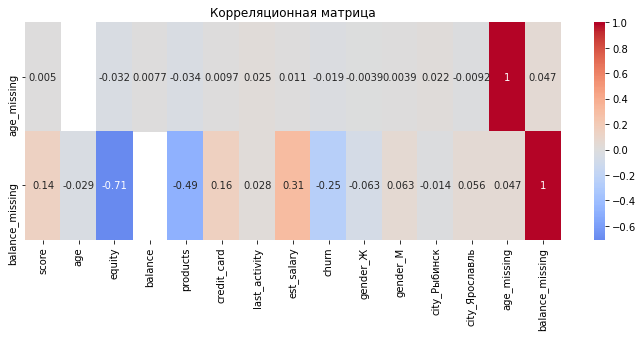

In [11]:
plt.figure(figsize=(12, 4))
sns.heatmap(corr_matrix_ab, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

Как можно наблюдать из матрицы корреляции, пропуски в столбце age не имеют корреляции с каким-либо признаком. А вот balance_missing имеет высокую корреляцию с баллами собственности (equity), слабую корреляцию с количеством продуктов (products), оценочным уровнем зарплаты (est_salary) и признаком отока (churn).

По полученным коэффициентам корреляции можно сделать вывод, что пропуски в столбце age могут быть отнесены к категории MCAR (Missing Completely At Random / Отсутствует совершенно случайно): пропуски не зависят от других переменных и не ведут к систематической ошибке. Можем оставить их без изменений.

Пропуски в столбце balance, в виду наличия корреляции с некоторыми признаками, можно отнести к категории MNAR (Missing Not At Random / Отсутствует не случайно): наличие пропусков зависит от значений других признаков. Поскольку пропуски зависят от данных, их нельзя просто отбросить или заполнить одним значением без риска искажения данных, следовательно, оставим все пропуски без изменений для минимизации погрешности.

Пропуски и их категории выяснены, перейдем к изучению наличия дубликатов в таблице.

In [12]:
print('Количество дубликатов в таблице:', data.duplicated().sum())

Количество дубликатов в таблице: 0


Явные дубликаты в таблице отсуствуют, однако, стоит проверить отдельно дубликаты по столбцу user_id для более полного анализа.

In [13]:
print('Количество дубликатов в по столбцу user_id:', data['user_id'].duplicated().sum())

Количество дубликатов в по столбцу user_id: 73


Найдено 73 дубликата по столбцу user_id, однако, это еще не стимул к удалению этих строк. Поскольку, в нашем датафрейме присутствует информация о клиентах из нескольких филиалов, рассмотрим строки с дублирующимися значениями user_id.

In [14]:
#создаем переменную с дубликатами по user_id
duplicates = data[data['user_id'].duplicated(keep=False)]

#группируем таблицу по user_id
grouped = duplicates.groupby('user_id')

#цикл для попарного выведения user_id
for userid, group in grouped:
    print(f'Дубликаты для user_id: {userid}')
    for index, row in group.iterrows():
        print(row.to_dict())
    print('\n')



Дубликаты для user_id: 116540
{'user_id': 116540, 'score': 883.0, 'age': 55.0, 'equity': 1, 'balance': 362756.49, 'products': 3, 'credit_card': 0, 'last_activity': 1, 'est_salary': 175920.48, 'churn': 1, 'gender_original': 'Ж', 'gender_Ж': 1, 'gender_М': 0, 'city_original': 'Рыбинск', 'city_Рыбинск': 1, 'city_Ярославль': 0, 'age_missing': 0, 'balance_missing': 0}
{'user_id': 116540, 'score': 887.0, 'age': 38.0, 'equity': 0, 'balance': nan, 'products': 1, 'credit_card': 0, 'last_activity': 1, 'est_salary': 119247.61, 'churn': 0, 'gender_original': 'Ж', 'gender_Ж': 1, 'gender_М': 0, 'city_original': 'Ярославль', 'city_Рыбинск': 0, 'city_Ярославль': 1, 'age_missing': 0, 'balance_missing': 1}


Дубликаты для user_id: 117943
{'user_id': 117943, 'score': 855.0, 'age': 32.0, 'equity': 6, 'balance': 1036832.93, 'products': 4, 'credit_card': 1, 'last_activity': 1, 'est_salary': 107792.71, 'churn': 1, 'gender_original': 'Ж', 'gender_Ж': 1, 'gender_М': 0, 'city_original': 'Рыбинск', 'city_Рыбинск

При попарном рассмотрении по user_id, можем наблюдать, что при одинаковом значении user_id остальные столбцы имеют разное наполнение - что свидетельствует о том, что это не дубликаты, а разные user_id для пользователей из разных отделений банка (городов).

**<center>Выводы и наблюдения первого этапа**

На этапе предобработки данных была загружена таблица, получена общая информация о ней. Типы данных соответствуют значениям - этот пункт остался без изменений. Обнаружены пропуски по столбцым age и balance: 
пропуски в столбце age отнесены к категории MCAR (Missing Completely At Random / Отсутствует совершенно случайно), а пропуски в столбце balance, в виду наличия корреляции с некоторыми признаками, отнесены к категории MNAR (Missing Not At Random / Отсутствует не случайно). Все NaN-значения были оставлены без изменений во избежании погрешности при дальнейшем исследовании данных. 
Явных дубликатов не было обнаружено, но, были определены дубликаты по столбцу user_id, которые при проверки оказалисть пользователями из разных отделений банка.

Также, для последующего анализа были закодировны переменные столбцов "gender" и "city".

### Исследовательский анализ данных.

Для начала, получим основные статистические показатели для оставшихся пользователей и пользователей, прекративших использование услуг банка. 

#### Получение общих статистических сведений для пользователей в разрезе оттока

In [15]:
#создаем срез с пользователями, прекратившими использование банковских услуг
data_churn = data.query('churn == 1')
#настройка вывода чисел для оптимального формата отображения баланса
pd.options.display.float_format = '{:.2f}'.format
#выводим описательную статистику в разрезе оттока
display(data_churn.describe())

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Рыбинск,city_Ярославль,age_missing,balance_missing
count,1820.00,1820.00,1819.00,1820.00,1807.00,1820.00,1820.00,1820.00,1820.00,1820.00,1820.00,1820.00,1820.00,1820.00,1820.00,1820.00
mean,170962.35,863.40,41.45,3.76,1133993.27,2.38,0.55,0.70,148243.01,1.00,0.35,0.65,0.24,0.61,0.00,0.01
std,35289.61,49.61,11.18,1.59,2033978.25,0.92,0.50,0.46,122914.51,0.00,0.48,0.48,0.43,0.49,0.02,0.08
min,94561.00,706.00,18.00,0.00,6.00,0.00,0.00,0.00,10880.27,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,141300.50,828.00,32.00,3.00,387218.33,2.00,0.00,0.00,83111.32,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,170496.00,866.00,39.00,4.00,782410.47,2.00,1.00,1.00,125390.62,1.00,0.00,1.00,0.00,1.00,0.00,0.00
75%,201386.25,898.00,52.00,5.00,1348101.46,3.00,1.00,1.00,175952.93,1.00,1.00,1.00,0.00,1.00,0.00,0.00
max,229058.00,1000.00,79.00,9.00,64866210.15,5.00,1.00,1.00,1263028.49,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [16]:
#создаем срез с пользователями, которые продолжают пользоваться услугами банка
data_no_churn = data.query('churn == 0')
#выводим описательную статистику в разрезе оставшихся клиентов
display(data_no_churn.describe())

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Рыбинск,city_Ярославль,age_missing,balance_missing
count,8180.00,8180.00,8155.00,8180.00,5898.00,8180.00,8180.00,8180.00,8180.00,8180.00,8180.00,8180.00,8180.00,8180.00,8180.00,8180.00
mean,172004.36,845.43,43.02,2.37,733982.59,1.76,0.71,0.48,147783.20,0.00,0.53,0.47,0.28,0.58,0.00,0.28
std,33345.47,68.05,12.38,1.97,1954572.71,0.71,0.45,0.50,142802.38,0.00,0.50,0.50,0.45,0.49,0.06,0.45
min,95384.00,642.00,18.00,0.00,0.00,1.00,0.00,0.00,2546.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,143105.50,796.00,34.00,0.00,279348.67,1.00,0.00,0.00,73506.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,173218.00,848.00,40.00,3.00,475382.45,2.00,1.00,0.00,118257.71,0.00,1.00,0.00,0.00,1.00,0.00,0.00
75%,201260.25,900.00,51.00,4.00,853926.94,2.00,1.00,1.00,173990.12,0.00,1.00,1.00,1.00,1.00,0.00,1.00
max,229145.00,1000.00,86.00,9.00,119113552.01,5.00,1.00,1.00,1395064.45,0.00,1.00,1.00,1.00,1.00,1.00,1.00


Основные различия, обнаруженные при изучении статистики по клиентам в разрезе оттока и оставшихся:
 - Возраст
   
   Средний возраст **ушедших** клиентов - 41.45 лет
   
   Средний возраст **оставшихся** клиентов - 43.02 лет


- Баланс

    Средний баланс **ушедших** клиентов - 1,133,993.27
    
    Средний баланс **оставшихся** клиентов - 733,982.59
    
    
- Количество продуктов

    Среднее количество продуктов **ушедших** клиентов - 2.38
    
    Среднее количество продуктов **оставшихся** клиентов - 1.76
    
    
- Наличие кредитной карты

     55% **ушедших** клиентов имели кредитную карту
     
     71% **оставшихся** клиентов имеют кредитную карту
     
     
- Баллы собственности
  
    Среднее количество баллов собственности **ушедших** клиентов - 3.76
    
    Среднее количество баллов собственности **оставшихся** клиентов - 2.37
    

Уже на данном этапе можно проследить различия между группами ушедших и оставшихся клиентов, однако, по этим данных выводы делать рано. При рассчете не учитываются выбросы, в данном случае изучение описательной статистики в разрезе групп помогает нам сузить детальное исследование до определенных параметров: следуют подробнее изучить вышеописанные признаки для установление портрета пользователя, переставшего использовать продукты банка.

Отфильтруем таблицу с помощью отсечения перцентилей. Это не даст нам 100% свободу от выбросов, однако, такое отсечение сможет немного их скорректировать без ручной проверки всех столбцов датафрейма на выбросы.

In [17]:
#задаем перцентили
lower_percentile = 0.01
upper_percentile = 0.99

#функция для отсечения перцентилей по всему датафрейму
def filter_by_percentile(df, lower_percentile, upper_percentile):
    df_filtered = df.copy()
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    for col in numeric_cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    return df_filtered

#фильтруем таблицу
data_filtr = filter_by_percentile(data, lower_percentile, upper_percentile)

#### Поиск взаимосвязей с помощью матрицы корреляции

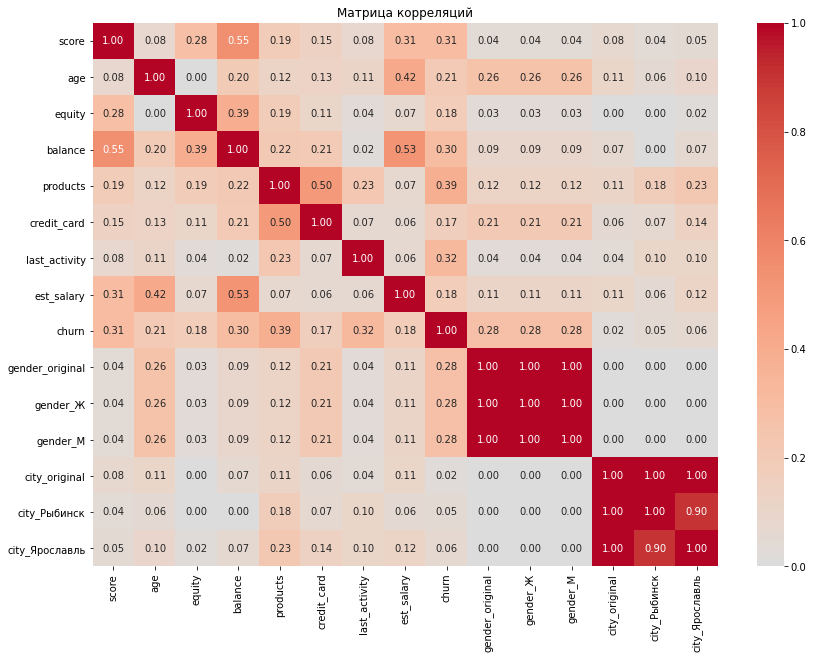

Полученные коэффициенты корреляции с признаком оттока (churn):
city_original: 0.02 (Очень слабая)
city_Рыбинск: 0.05 (Очень слабая)
city_Ярославль: 0.06 (Очень слабая)
credit_card: 0.17 (Слабая)
equity: 0.18 (Слабая)
est_salary: 0.18 (Слабая)
age: 0.21 (Слабая)
gender_original: 0.28 (Слабая)
gender_Ж: 0.28 (Слабая)
gender_М: 0.28 (Слабая)
balance: 0.30 (Умеренная)
score: 0.31 (Умеренная)
last_activity: 0.32 (Умеренная)
products: 0.39 (Умеренная)


In [18]:
#перевод user_id в индексы
data_filtr.set_index('user_id', inplace=True)
#удаление столбцов с кодированными пропусками значений
data_filtr = data_filtr.drop(columns=['age_missing', 'balance_missing'])

#определяем непрерывные признаков
interval_cols = ['score', 'age', 'balance', 'est_salary']
#вычисляем матрицу корреляции с помощью phik
phik_matrix = data_filtr.phik_matrix(interval_cols=interval_cols)

#визуализируем матрицу корреляции
plt.figure(figsize=(14, 10))
sns.heatmap(phik_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

#сортируем коэффициенты корреляции для последующего вывода
churn_corr = phik_matrix['churn'].drop('churn').sort_values()

#цикл для вывода коэффииента корр с интерпритацией по шкале Чеддока
print('Полученные коэффициенты корреляции с признаком оттока (churn):')
for feature, corr_value in churn_corr.items():
    if abs(corr_value) < 0.1:
        strength = 'Очень слабая'
    elif abs(corr_value) < 0.3:
        strength = 'Слабая'
    elif abs(corr_value) < 0.5:
        strength = 'Умеренная'
    elif abs(corr_value) < 0.7:
        strength = 'Заметная'
    elif abs(corr_value) < 0.9:
        strength = 'Высокая'
    else:
        strength = 'Очень высокая'
    print(f"{feature}: {corr_value:.2f} ({strength})")


По результатам корреляционного анализа выделено 4 умеренных корреляции:
- отток-баланс (клиенты с более высоким балансом имеют большую склонность к оттоку);
- отток-кредитный скоринг (более высокие баллы кредитного скоринга связаны с большей вероятностью оттока);
- отток-последняя активность (более активные клиенты более склонны к уходу.);
- отток-количество продуктов (клиенты с меньшим количеством продуктов более склонны к уходу).

Однако, основываясь только на полученных коэффициентах корреляции, мы не сможешь построить портрет ушедшего пользователя. Далее необходимо более детально просмотреть распределение признаков с учтом оттока.


#### Выделение пользователей, прекративших использование продуктов.

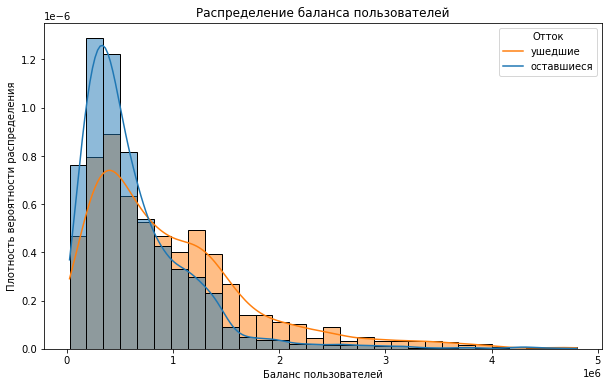

In [19]:
#задаем график распределения баланса с учетом оттока
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtr, x='balance', hue='churn', stat='density', common_norm=False, bins=30, kde=True)
plt.title('Распределение баланса пользователей')
plt.legend(title='Отток', labels=['ушедшие', 'оставшиеся'])
plt.xlabel('Баланс пользователей')
plt.ylabel('Плотность вероятности распределения')
plt.show()

На графике представлено распределение баланса пользователей с учетом оттока (ушедшие и оставшиеся пользователи). Можем наблюдать, что обе группы клиентов имеют пик баланса в районе 0.5 миллиона, однако, у ушедших клинетов более длинный хвост, что свидетельствует о более высоком балансе именно у ушедших клиентов. Исходя из этого, можно сделать вывод, что клиенты с более высоким балансом склонны к уходу из банка. Это требует разработки стратегий удержания, ориентированных на эту группу клиентов, чтобы снизить уровень оттока и улучшить общую клиентскую базу банка.

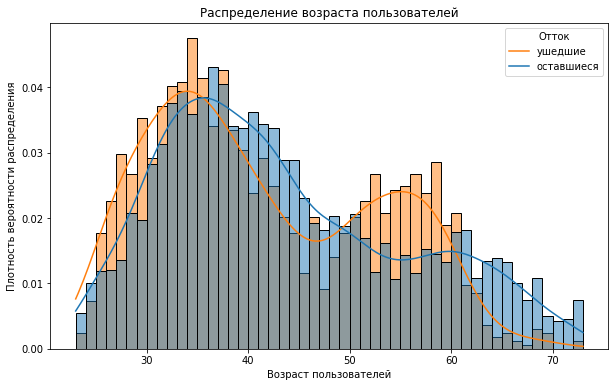

In [20]:
#задаем график распределения баланса с учетом оттока
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtr, x='age', hue='churn', stat='density', common_norm=False, binwidth=1, kde=True)
plt.title('Распределение возраста пользователей')
plt.legend(title='Отток', labels=['ушедшие', 'оставшиеся'])
plt.xlabel('Возраст пользователей')
plt.ylabel('Плотность вероятности распределения')
plt.show()

Рассмотрим график распределения возраста пользователей с учетом оттока. Пик плотности для оставшихся клиентов наблюдается в районе 30-40 лет, а для ушедших видны два пика: один около 35 лет, другой около 55 лет, что может указывать на значительное количество пользователей старшего возраста, склонных к оттоку. Однако, более всего склонны к оттоку молодые люди в возрасте 35-35 лет.
Однако, уровень оттока начинает возрастать уже с 25 лет с уменьшением плотности оттока после 37.
Полученные данные можно использовать для персонализации меркетинговых стратегий, т.к. у молодежи и пожилых клиентов могут быть разные предпочтения, не учетываемые банком, что и повышает вероятность их оттока. 

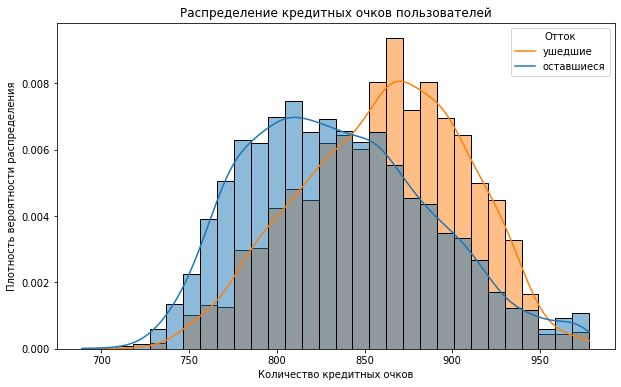

In [21]:
#задаем график распределения кредитных очков с учетом оттока
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtr, x='score', hue='churn', stat='density', common_norm=False, bins=30, kde=True)
plt.title('Распределение кредитных очков пользователей')
plt.legend(title='Отток', labels=['ушедшие', 'оставшиеся'])
plt.xlabel('Количество кредитных очков')
plt.ylabel('Плотность вероятности распределения')
plt.show()

Большинство лояльных пользователей имеют рейтинг кредитных очков на уровне  770-870 очков, в то время как пик плотности ушедших пользователей приходится на 870-900 очков. Также можем наблюдать более равномерное распределение очков у оставшихся пользователей, в то время как у ушедших распределение смещено вправо с достаточно высокой плотностью распределения. Все это говорит о том, что клиенты с более высокими кредитными очками (от 850 и выше) имеют большую склонность к оттоку, включая тех, чей уровень кредитных очков превышает 900, где также наблюдается преобладание оттока над лояльностью.

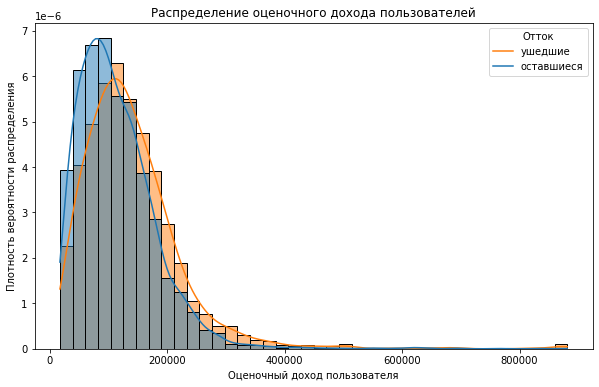

In [22]:
#задаем график распределения оценочного дохода с учетом оттока
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtr, x='est_salary', hue='churn', stat='density', common_norm=False, bins=40, kde=True)
plt.title('Распределение оценочного дохода пользователей')
plt.legend(title='Отток', labels=['ушедшие', 'оставшиеся'])
plt.xlabel('Оценочный доход пользователя')
plt.ylabel('Плотность вероятности распределения')
plt.show()

На графике распределения оценочного дохода мы можем наблюдать, что распределение дохода у оставшихся пользователей имеет пик в диапазоне 100000-150000, в то время как у ушедших пользователей пик приходится на примерно такой же диапазон, однако распределение у ушедших клиентов более равномерно и смещено вправо - клиенты с более высоким оценочным доходом (свыше 200000) также имеют тенденцию к оттоку. 

Рассмотрим уровень оттока по категориальным переменным. 

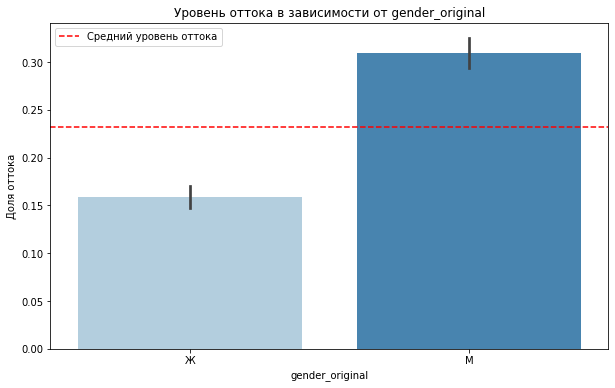

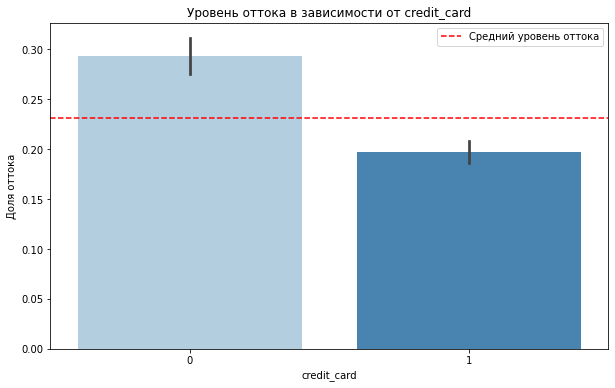

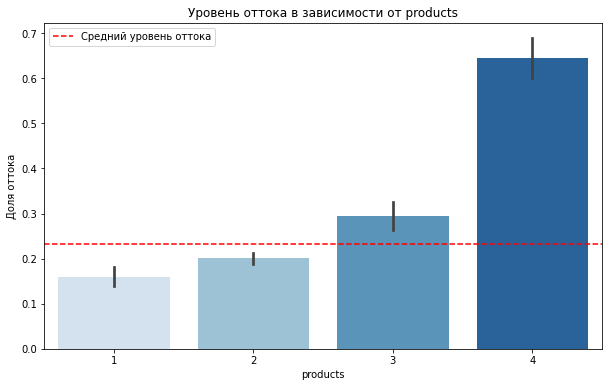

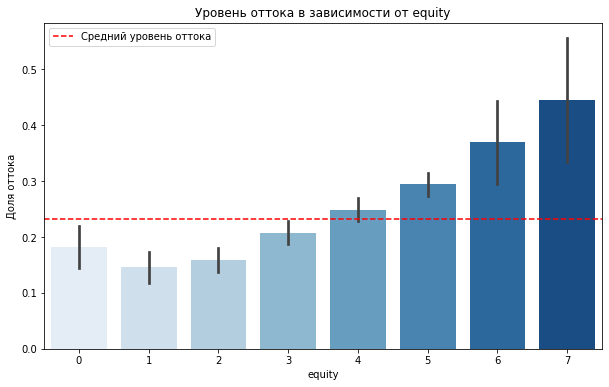

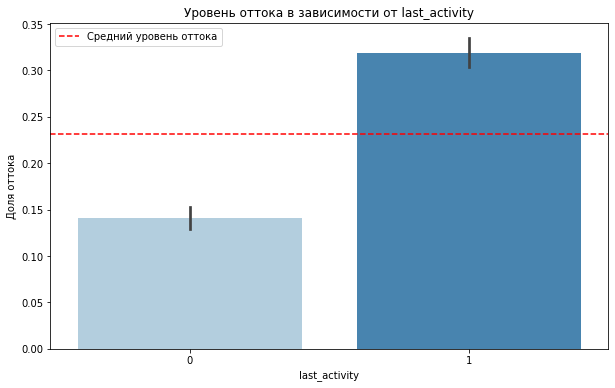

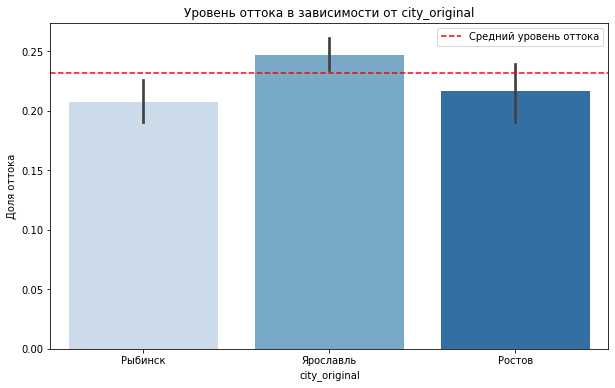

In [23]:
#задаем средний уровень оттока
average_churn = data_filtr['churn'].mean()

#передаем в список категориальные переменные
categorical = ['gender_original', 'credit_card', 'products', 'equity','last_activity', 'city_original']

#цикл для построения графиков
for item in categorical:
    plt.figure(figsize=(10, 6))
    graph = sns.barplot(x=item, y='churn', data=data_filtr, palette='Blues')
    line = plt.axhline(average_churn, color='red', linestyle='--')
    plt.title(f'Уровень оттока в зависимости от {item}')
    plt.xlabel(item)
    plt.ylabel('Доля оттока')
    
    #добавляем легенду с линией среднего оттока
    handles, labels = graph.get_legend_handles_labels()
    handles.append(line)
    labels.append('Средний уровень оттока')
    plt.legend(handles=handles, labels=labels)
    plt.show()


Проанализируем полученные графики:
- Уровень оттока в зависимости от **пола**

Наблюдаем, что мужчины (1) имеют значительно более высокий уровень оттока (около 32%) по сравнению с женщинами (0), у которых уровень оттока составляет около 16%. Прохождение линии среднего уровня оттока указывает на то, что мужчины более склонны к уходу из банка, чем женщины.

- Уровень оттока в зависимости от наличия **кредитной карты**

График показывает, что пользователи без кредитной карты (0) имеют значительно более высокий уровень оттока (около 30%) по сравнению с пользователями, имеющими кредитную карту (1), у которых уровень оттока составляет около 20%.

- Уровень оттока в зависимости от **количества продуктов**

У пользователей с 1 продуктом уровень оттока самый низкий (около 17%), что значительно ниже среднего уровня оттока. Для пользователей с 2 продуктами уровень оттока можно считать средним (около 20%), в то время как у пользователей с 3 и более продуктами уровень оттока снова повышается, превышая средний уровень, особенно заметен скачок для пользователей с 4 продуктами (≈65%). 
- Уровень оттока в зависимости от **баллов собственности**

График уровня оттока в зависимости от баллов собственности показывает, что пользователи с низкими баллами собственности (0-3) имеют относительно низкий уровень оттока, в то время как пользователи с высокими баллами собственности (5-9) более склонны к уходу. 

- Уровень оттока в зависимости от **активности**

Доля оттока для активных пользователей значительно выше средней и составляет около 33%. Это указывает на то, что активные пользователи более склонны к оттоку.

- Уровень оттока в зависимости от **города**
 
Более всего склонные к оттоку пользователи из Ярославля. 

Построим статистический портрет оставшегося и ушедшего пользователей.

In [24]:
#создаем переменные в разрезах оттока и нет с учетом удаления выбросов
data_filtr_churn = data_filtr.query('churn == 1')
data_filtr_no_churn = data_filtr.query('churn == 0')

In [25]:
#создаем словарь с расчетом портрета пользователей
summary = {
    'Признак': ['Средняя зарплата', 'Средний баланс', 'Среднее количество кредитных очков' , 'Средний возраст', 'Медианное количество продуктов', 'Медианное количество кредитных карт', 'Медианное количество собственности', 'Мода по городу', 'Мода по полу', 'Мода по активности',],
    'Отток': [
        data_filtr_churn['est_salary'].mean(),
        data_filtr_churn['balance'].mean(),
        data_filtr_churn['score'].mean(),
        data_filtr_churn['age'].mean(),
        data_filtr_churn['products'].median(),
        data_filtr_churn['credit_card'].median(),
        data_filtr_churn['equity'].median(),
        data_filtr_churn['city_original'].mode()[0],
        data_filtr_churn['gender_original'].mode()[0],
        data_filtr_churn['last_activity'].mode()[0]
    ],
    'Не отток': [
        data_filtr_no_churn['est_salary'].mean(),
        data_filtr_no_churn['balance'].mean(),
        data_filtr_no_churn['score'].mean(),
        data_filtr_no_churn['age'].mean(),
        data_filtr_no_churn['products'].median(),
        data_filtr_no_churn['credit_card'].median(),
        data_filtr_no_churn['equity'].median(),
        data_filtr_no_churn['city_original'].mode()[0],
        data_filtr_no_churn['gender_original'].mode()[0],
        data_filtr_no_churn['last_activity'].mode()[0]
    ],
    'Относительная разница': [
        (data_filtr_churn['est_salary'].mean() - data_filtr_no_churn['est_salary'].mean()) / data_filtr_no_churn['est_salary'].mean(),
        (data_filtr_churn['balance'].mean() - data_filtr_no_churn['balance'].mean()) / data_filtr_no_churn['balance'].mean(),
        (data_filtr_churn['score'].mean() - data_filtr_no_churn['score'].mean()) / data_filtr_no_churn['score'].mean(),
        (data_filtr_churn['age'].mean() - data_filtr_no_churn['age'].mean()) / data_filtr_no_churn['age'].mean(),
        '-', '-', '-', '-', '-', '-'
    ]
}

#конфертируем словарь в таблицу
user_portrait = pd.DataFrame(summary)

#отображение итоговой таблицы
display(user_portrait)

,Признак,Отток,Не отток,Относительная разница
0,Средняя зарплата,138988.10,114333.95,0.22
1,Средний баланс,969482.87,642805.57,0.51
2,Среднее количество кредитных очков,861.13,835.27,0.03
3,Средний возраст,41.50,43.24,-0.04
4,Медианное количество продуктов,2.00,2.00,-
5,Медианное количество кредитных карт,1.00,1.00,-
6,Медианное количество собственности,4.00,3.00,-
7,Мода по городу,Ярославль,Ярославль,-
8,Мода по полу,М,Ж,-
9,Мода по активности,1,0,-


Исходя из этой таблицы, можно сделать вывод, что портреты пользователей не имебт кардинальных различий, кроме пола - мужчины более склонны к оттоку, и медианы количества собственности: больше собсветнности - больше шансы оттока. Различия по средней зарплате и возрасту можно считать незначительным.

Для построения портрета пользователя, прежде всего, нужно учитывать ВСЕ полученные результаты. 

#### Составление портрета пользователя, прекратившего использование продуктов банка

Исходя из всех полученных результатов можно построить 2 портрета пользователей, покинувших банк.

**<center>Портрет 1**
Общая характеристика: Молодой пользователь с высокой зарплатой и высоким уровнем кредитных очков.
    
Возраст: 25-35 лет
    
Средняя зарплата: Высокая (свыше 1.5 млн)
    
Баланс: Высокий (свыше 1 млн)
    
Кредитные очки: Высокие (850 и выше)
    
Активность: Да
    
Количество продуктов: 3 или более
    
Пол: Мужчина
    
Предполодительная причина оттока: поиск лучших условий с более выгодными предложениями. Из-за высокого кредитного рейтинга другие банки могут переманить пользователя более выгодными услугами. Также, влияет молодой возраст, что способствует более "продвинутому" изучения рынка.
 

**<center>Портрет 2** 
Общая характеристика: Пользователь среднего возраста с высоким балансом и очками собственности
    
Возраст: 50-60 лет
    
Средняя зарплата: Высокая (свыше 1.5 млн)
    
Баланс: Высокий (более 1 миллиона)
    
Баллы собственности: Высокие (5-9)
    
Активность: Да
    
Количество продуктов: 3 или более
    
Пол: Мужчина
    
Предполодительная причина оттока: могут быть заинтересованы в поисках банка с улучшенными предложениями по инвестициям.
    
    



**<center>Выводы и наблюдения второго этапа**
    
На данном этапе было проведено разделение пользователей по признаку оттока и исследование их статистических параметров для определения основных различий и направления вектора исследования. 
В ходе последующего анализа были проведены корреляционный анализ, построение и анализ графиков, а также определены портреты клиентов, склонных к оттоку. Результаты показали, что клиенты-мужчины, с высокой зарплатой, балансом, кредитными очками и баллами собственности, а также активные пользователи более склонны к оттоку.

### Формулировка и проверка гипотез.

В рамках этапа формулировки и проверки гипотез необходимо уточнить статистическую достоверность полученных ранее результатов. Имея подтвержденные/отверженные гипотезы по основным признакам оттока, сегменты будут составлены более корректно.
Проверим:
- равенство дохода;
- равенство используемых продуктов;
- равенство баллов собственности;
- равенство возраста клиентов;
- равенство кредитного рейтинга.

#### Гипотеза о различии среднего дохода между клиентами, которые ушли, и теми, которые остались

Первой будем проверять гипотезу о различии среднего дохода. Сформируем нулевую и альтернативную гипотезы:

**H₀**: средние доходы оставшихся и ушедших клиентов **равны**;

**H₁**: средние доходы оставшихся и ушедших клиентов **не равны**.

Перед проведением статистического теста необходимо проверить условия, благодаря которым будет определет статистический тест для анализа - рассмотрим выбросы и количество наблюдений, поскольку согласно ЦПТ, если размер выборки велик, можно не проверять нормальность распределения.

In [26]:
#выводим количество наблюдений для каждой из групп(размер выборок)
print(f'Размер выборки для оттока: {len(data_filtr_churn)}')
print(f'Размер выборки для не оттока: {len(data_filtr_no_churn)}')

Размер выборки для оттока: 1642
Размер выборки для не оттока: 5448


Размер выборок достаточный, согласно ЦПТ можно использовать ttest. Проверим выбросы в выборках с помощью диаграммы размаха.

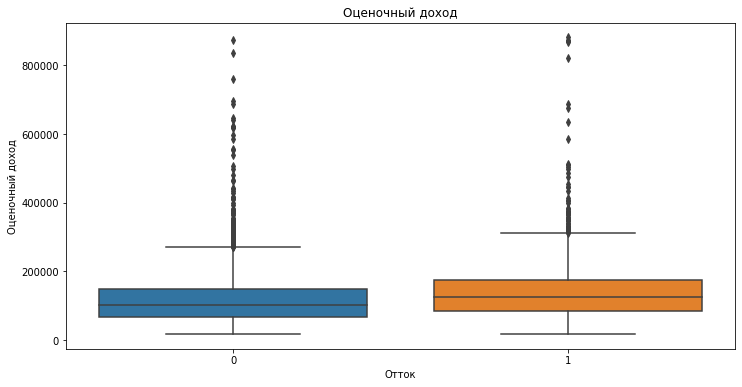

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='churn', y='est_salary', data=data_filtr)
plt.title('Оценочный доход')
plt.xlabel('Отток')
plt.ylabel('Оценочный доход')
plt.show()

Можем наблюдать множественные выбросы каждой из групп. Выбросы наблюдаются свыше 250000. Отфильтруем датафрейм - оставим доход менее 250000.

In [28]:
#отсекаем зарплату свыше 250000
filtr_churn_salary = data_filtr_churn[data_filtr_churn['est_salary'] <= 250000]['est_salary']
filtr_no_churn_salary = data_filtr_no_churn[data_filtr_no_churn['est_salary'] <= 250000]['est_salary']

#проверяем размер выборок после фильтрации
print(f'Размер выборки для оттока: {len(filtr_churn_salary)}')
print(f'Размер выборки для не оттока: {len(filtr_no_churn_salary)}')

Размер выборки для оттока: 1521
Размер выборки для не оттока: 5270


Размер выборок остался достаточным для проведения t-теста. Следовательно, переходим непосредственно к проведению двустороннего t-теста.

In [29]:
#проводим t-тест
alpha = 0.05
results = st.ttest_ind(filtr_churn_salary, filtr_no_churn_salary, equal_var=False)

print('Средний доход ушедших клиентов:', pd.Series(filtr_churn_salary).mean())
print('Средний доход оставшихся клиентов:', pd.Series(filtr_no_churn_salary).mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний доход ушедших клиентов: 122244.00244575937
Средний доход оставшихся клиентов: 106899.98606261858
p-значение: 2.93965370775058e-22
Отвергаем нулевую гипотезу


Таким образом, благодаря проведенному тестированию мы можем уверенно заявлять о том, средние доходы оставшихся и ушедших клиентов **не равны**.

#### Гипотеза о различии среднего количества используемых продуктов


В ранее проанализированных графиках было обнаружено, что пользователи, имеющих более 5 продуктов более склонны к оттоку. На основе этого результата сформируем гипотезы:

**H₀**: среднее количество продуктов, используемых ушедшими и оставшимися клиентами, **равно**;

**H₁**: среднее количество продуктов, используемых ушедшими и оставшимися клиентами, **не равно**.

Данные параметр не предполагает наличия выбросов, а размер выборки (до фильтрации параметра зарплаты) мы уже рассчитывали ранее, следовательно, переходим сразу к проведению двустороннего t-теста.

In [30]:
results = st.ttest_ind(data_filtr_churn['products'], data_filtr_no_churn['products'], equal_var=False)

print('Cреднее количество продуктов, используемых ушедшими клиентами:', pd.Series(data_filtr_churn['products']).mean())
print('Cреднее количество продуктов, используемых оставшимися клиентами:', pd.Series(data_filtr_no_churn['products']).mean())


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Cреднее количество продуктов, используемых ушедшими клиентами: 2.364190012180268
Cреднее количество продуктов, используемых оставшимися клиентами: 1.97136563876652
p-значение: 4.5046648401777057e-57
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу - среднее количество продуктов, используемых ушедшими пользователя **не равно** среднему у оставшихся. Исходя из средних значений можем утверждать, что у ушедших пользователей среднее количество продуктов больше. 

#### Гипотеза о различии среднего количества баллов собственности


Во время проведения исследовательского анализа данных также был обнаружен повышенный уровень оттока у пользователей, имеющих более высокое значение баллов собственности. Сформируем гипотезы:

**H₀**: среднее значение баллов собсвенности у ушедших клиентов **не больше**, чем среднее количество баллов собственности у оставшихся клиентов;

**H₁**: среднее значение баллов собсвенности у ушедших клиентов **больше**, чем среднее количество баллов собственности у оставшихся клиентов;

Также приступаем сразу к проведению правостороннего t-теста, т.к. размер выборки по ЦПТ позволяет провести t-тест, а данный парамент не предполагает наличие выбросов. 

In [31]:
print('Cреднее значение баллов собсвенности у ушедших клиентов:', pd.Series(data_filtr_churn['equity']).mean())
print('Cреднее значение баллов собсвенности у оставшихся клиентов:', pd.Series(data_filtr_no_churn['equity']).mean())

#проводим t-тест
results = st.ttest_ind(data_filtr_churn['equity'], data_filtr_no_churn['equity'], equal_var=False, alternative='greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Cреднее значение баллов собсвенности у ушедших клиентов: 3.7496954933008526
Cреднее значение баллов собсвенности у оставшихся клиентов: 3.270741556534508
p-значение:  5.064565886798264e-29
Отвергаем нулевую гипотезу


Нулевая гипотеза отвержена - у ушедших клиентов среднее значение баллов собственности **выше**, чем у оставшихся клиентов.

#### Гипотеза о различии среднего возраста клиентов


Одним из признаков оттока также является возраст клиентов - было определено, что оттоку больше склонны молодые (30-35 лет) и более возрастные клиенты (ок. 55 лет). Однако, более молодые клиенты потенциально дольше могут сотрудничать с банком. Поэтому, гипотезы будут звучать следующим образом:

**H₀**: средний возраст ушедших клиентов **не меньше**, чем средний возраст оставшихся клиентов;

**H₁**: средний возраст ушедших клиентов **меньше**, чем средний возраст оставшихся клиентов.

В отстутствии выбросов в возрасте клиентов мы не можем быть уверены, т.к. возможно наличие некоторых очень старых/молодых пользователей. Для удостоверения отсутствия выбросов построим диаграмму размаха возраста.

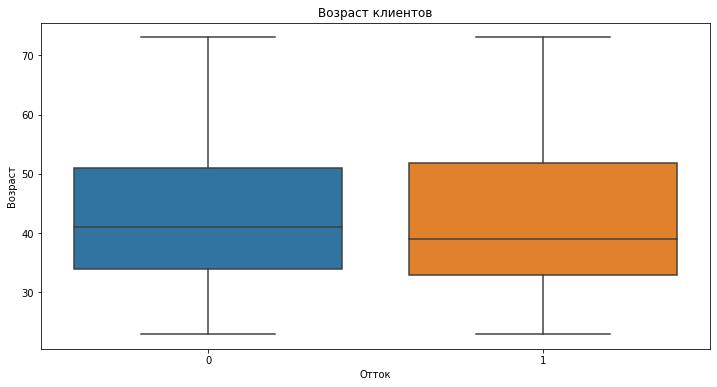

In [32]:
#проверка возраста на выбросы
plt.figure(figsize=(12, 6))
sns.boxplot(x='churn', y='age', data=data_filtr)
plt.title('Возраст клиентов')
plt.xlabel('Отток')
plt.ylabel('Возраст')
plt.show()

Выбросы отсутствуют, переходим к проведению левостороннего t-теста.

In [33]:
print('Cредний возраст ушедших клиентов:', pd.Series(data_filtr_churn['age']).mean())
print('Cредний возраст оставшихся клиентов:', pd.Series(data_filtr_no_churn['age']).mean())

results = st.ttest_ind(data_filtr_churn['age'],data_filtr_no_churn['age'], equal_var=False, alternative='less')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Cредний возраст ушедших клиентов: 41.4993909866017
Cредний возраст оставшихся клиентов: 43.23788546255506
p-значение:  1.995390975506333e-08
Отвергаем нулевую гипотезу


Нулевая гипотеза отвержена - средний возраст ушедших клиентов **меньше**, чем у оставшихся. 

#### Гипотеза о различии среднего уровня кредитной оценки


При изучении графика распределения кредитных очков в разрезе оттока было обнаружено, что у ушедших пользователей кредитные очки выше. Проверим это статистически.

**H₀**: средний уровень кредитной оценки ушедших клиентов **не больше**, чем средний уровень кредитной оценки оставшихся клиентов;

**H₁**: средний уровень кредитной оценки ушедших клиентов **больше**, чем средний уровень кредитной оценки оставшихся клиентов.

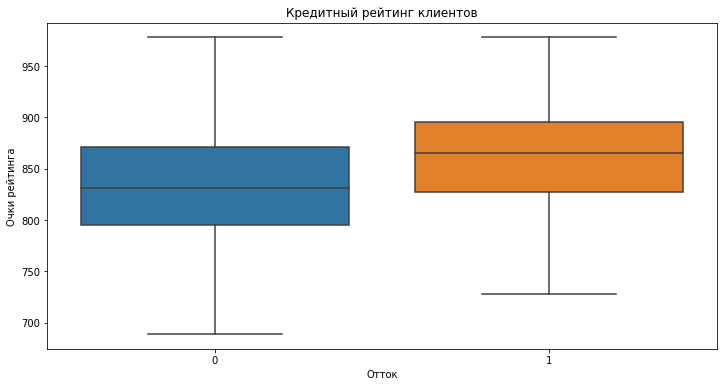

In [34]:
#проверка кредитных очков  на выбросы
plt.figure(figsize=(12, 6))
sns.boxplot(x='churn', y='score', data=data_filtr)
plt.title('Кредитный рейтинг клиентов')
plt.xlabel('Отток')
plt.ylabel('Очки рейтинга')
plt.show()

Как и в предыдущих тестированиях гипотез, переходим к проведению правостороннего t-теста.

In [35]:
print('Средний уровень кредитной оценки ушедших клиентов:', pd.Series(data_filtr_churn['score']).mean())
print('Средний уровень кредитной оценки оставшихся клиентов:', pd.Series(data_filtr_no_churn['score']).mean())

results = st.ttest_ind(data_filtr_churn['score'], data_filtr_no_churn['score'], equal_var=False, alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний уровень кредитной оценки ушедших клиентов: 861.1327649208282
Средний уровень кредитной оценки оставшихся клиентов: 835.2712922173274
p-значение: 6.327189704579357e-77
Отвергаем нулевую гипотезу


Нулевая гипотеза отвержена - у ушедших клиентов баллы кредитного скоринга **выше**.

**<center>Выводы и наблюдения третьего этапа**

На основании проведенных тестирований можно уверенно заявить, что средние доходы ушедших и оставшихся клиентов статистически значимо различаются. Ушедшие клиенты имеют большее среднее количество продуктов, большее среднее значение баллов собственности и более высокие баллы кредитного скоринга по отношению к оставшимся клиентам. Кроме того, средний возраст ушедших клиентов оказался меньше, чем у оставшихся. Эти результаты помогут сегментировать и приоритизировать пользователей, на которых стоит обратить внимание для увеличения их лояльности и уменьшения вероятности оттока.

### Промежуточный вывод

Таким образом, по результатам исследовательского анализа данных и проверки гипотез, было обнаружено и подтверждено, что:
- Ушедшие клиенты имеют более высокий средний доход;
- Ушедшие клиенты используют в среднем больше продуктов, чем оставшиеся;
- Ушедшие клиенты имеют более высокие баллы собственности;
- Ушедшие клиенты младше оставшихся;
- Ушедшие клиенты имеют более высокие баллы кредитного скоринга.

Все вышеперечисленные признаки лягут в основу сегментации клиентов с целью более точного определения пользователей, склонных к оттоку, и разработки персонализированных стратегий удержания данных клиентов.

### Сегментация пользователей

#### Сегментация польователей

Приступим к выделению сегментов пользователей.
**<center>Сегмент 1**
    
В основу первого сегмента будет заложен портрет ушедшего пользователя, поскольку есть высокая вероятность, что оставшиеся клиенты с такими же характеристиками вскоре покинут банк. Для того, что сегмент был и не очень широкий, и не очень узкий, остановимся на основынх критериях:
    
    - Пол: мужской;
    - Возраст: 30-35 лет;
    - Кредитные очки: 800+
    

In [36]:
segment1 = data_filtr.query('age >= 25 & age <= 35 & gender_М == 1 & score >= 800 & score <= 950')
display(segment1)
print('Количество пользователей, попавших в сегмент 1:', len(segment1))
print('Процент отточных клиентов в сегменте 1:', (len(segment1.query('churn==1'))/len(segment1))*100)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_original,gender_Ж,gender_М,city_original,city_Рыбинск,city_Ярославль
user_id,,,,,,,,,,,,,,,
172138,815.00,35.00,5,547499.87,2,1,1,105883.26,0,М,0,1,Ярославль,0,1
129705,811.00,34.00,2,129799.35,1,0,0,96242.71,1,М,0,1,Рыбинск,1,0
118849,826.00,31.00,4,333330.99,1,1,1,46981.53,0,М,0,1,Ярославль,0,1
208625,831.00,28.00,2,75005.22,2,1,0,70283.32,0,М,0,1,Ростов,0,0
115677,820.00,34.00,2,237691.16,2,1,0,23243.72,0,М,0,1,Ростов,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218170,841.00,29.00,2,235287.10,2,1,1,137494.06,1,М,0,1,Ярославль,0,1
190822,801.00,29.00,0,34300.30,2,1,1,107483.12,0,М,0,1,Ярославль,0,1
158678,889.00,35.00,4,880534.89,4,1,1,126564.61,0,М,0,1,Ярославль,0,1


Количество пользователей, попавших в сегмент 1: 910
Процент отточных клиентов в сегменте 1: 40.76923076923077


**<center>Сегмент 2**
    
В основу второго сегмента также будет заложен портрет ушедшего пользователя, с некоторыми другими комбинаторными признаками. 
    
    - Баланс: свыше 1 млн;
    - Количество продуктов: 3+;
    - Баллы собственности: 4+

In [37]:
segment2 = data_filtr.query('balance >= 100000.00 & products >= 3 & equity >= 4')
display(segment2)
print('Количество пользователей, попавших в сегмент 2:', len(segment2))
print('Процент отточных клиентов в сегменте 2:', (len(segment2.query('churn==1'))/len(segment2))*100)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_original,gender_Ж,gender_М,city_original,city_Рыбинск,city_Ярославль
user_id,,,,,,,,,,,,,,,
146556,861.00,37.00,5,850594.33,3,1,0,86621.77,0,Ж,1,0,Рыбинск,1,0
202305,856.00,56.00,4,863687.24,3,1,0,156619.80,0,М,0,1,Рыбинск,1,0
156677,873.00,39.00,5,915959.85,3,0,1,154034.62,1,М,0,1,Ярославль,0,1
213688,922.00,37.00,5,1214707.38,4,0,1,85121.07,0,Ж,1,0,Ярославль,0,1
223978,850.00,34.00,5,351583.16,4,0,1,115354.97,1,М,0,1,Рыбинск,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217489,893.00,49.00,5,1571192.11,4,1,1,151217.99,1,Ж,1,0,Ярославль,0,1
187204,957.00,35.00,4,3431029.03,4,1,0,354987.43,1,М,0,1,Ярославль,0,1
175730,816.00,36.00,4,477892.07,3,1,0,81100.60,0,М,0,1,Рыбинск,1,0


Количество пользователей, попавших в сегмент 2: 822
Процент отточных клиентов в сегменте 2: 45.01216545012166


**<center>Сегмент 3**
    
    - Кредитные очки: 800+;
    - Кредитная карта: отсутствует;
    - Оценочный уровень зарплаты: свыше 1,2 млн.

In [38]:
segment3 = data_filtr.query('score >= 800 & score <= 950 & credit_card == 0 & est_salary >= 120000.00')
display(segment3)
print('Количество пользователей, попавших в сегмент 2:', len(segment3))
print('Процент отточных клиентов в сегменте 2:', (len(segment3.query('churn==1'))/len(segment3))*100)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_original,gender_Ж,gender_М,city_original,city_Рыбинск,city_Ярославль
user_id,,,,,,,,,,,,,,,
225363,866.00,51.00,5,1524746.26,2,0,1,174423.53,1,Ж,1,0,Ярославль,0,1
136651,876.00,40.00,5,2307947.36,2,0,0,287010.61,0,М,0,1,Ярославль,0,1
219185,828.00,45.00,3,409634.94,2,0,0,134770.40,0,Ж,1,0,Ярославль,0,1
221927,863.00,39.00,5,1461423.33,1,0,1,221699.52,0,М,0,1,Ростов,0,0
214314,901.00,40.00,5,655642.36,2,0,0,224319.39,0,Ж,1,0,Ярославль,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197891,899.00,37.00,5,1422472.42,2,0,1,231978.68,1,М,0,1,Ярославль,0,1
154435,861.00,43.00,4,448896.95,3,0,0,169994.66,0,М,0,1,Рыбинск,1,0
205390,839.00,41.00,2,181974.12,2,0,0,146727.63,0,Ж,1,0,Рыбинск,1,0


Количество пользователей, попавших в сегмент 2: 943
Процент отточных клиентов в сегменте 2: 43.37221633085896


#### Приоритизация сегментов пользователей

Таким образом, было выделено 3 сегманта пользователей:
- **Сегмент 1**

В сегмент 1 были определены мужчины в возрасте 30-35 лет, с уровнем кредитных очков свыше 800. Процент отточных клиентов в данном сегменте 40.8%.

- **Сегмент 2**

В этот сегмент были определены пользователи с высоким балансом (свыше 1 млн), высокими баллами собственности (более 4), а также с 3 или более продуктами. Процент оттока в данном сегменте - 45.0%.

- **Сегмент 3**

В третий сегмент попали пользователи без кредитных карт, с высоким уровнем кредитных очков (800+) и высокой зарплатой (свыше 1.2 млн). Процент оттока в данном сегменте - 43.4%.


Для оценки приоритета сегментов предлагаю ориентироваться на проценты оттока в сегментах. Следовательно, **первостепенно** нужно обратить внимание на пользователей из **сегмента 2**, поскольку переход  таких пользователей в другой банк может быть вызван поиском лучших финансовых условий, депозитов, кэшбеков по остатку на счете.

Следующим по приоритету следуюет обработать **сегмент 3**, у которого уровень оотока меньше на 1.6%. Пользователи с такими характеристиками (в частности отсутствие кредитных карт) вероятнее переходят в другой банк из-за заинтересованности в предложениях кредитных карт с низкими процентными ставками, увеличенными овердрафтами.

Последний приоритет следует определить **сегменту 1**, поскольку мужчины молодого возраста могут искать другие банки с лучшими предложениями как по кредитованию, так и по предоставлению доступа рынка ценных бумаг и инвестированию (последнее предположение основано на тенденции современных молодых мужчин к инвестированию в акции, криптовалюты и т.д.).


### Рекомендации по итогам исследования

#### Рекомендации по сегменту 1

В виду молодого возраста клиентов и их высокого уровня кредитных очков рекомендую:

- **Персонализировать кредитные предложения.** 
Для данной категории клиентов увеличить кредитные лимиты и добавить возможность для кастомизации имеющихся банковских продуктов (например, добавление услуг изменения дизайна карты не только на стандартные шаблоны, а по пользовательским шаблонам).

- **Добавления статусности клиенту путем внедрения премиальных карт**. 
Премиальные карты следует выдавать за выполнение некоторых условий (высокий среднедневной остаток, поступление зарплаты свыше установленной суммы, количество проведенных транзакций свыше установленного количества). Премиальные карты следует снабдить определенными привелениями - например, проход в ВИП-залы аэропортов, кэшбек за покупки авиабилетов.

- **Улучшенные условия инвестирований**.
Предлагать услуги по составлению инвистиционного портфеля и его управления.

- **Добавить сервисы активного образа жизни**.
Предлагать программы и скидки на спортивные и фитнес-услуги, путешествия и развлечени.


#### Рекомендации по сегменту 2

Высокие баллы собственности и высокий доход предполагает интерес к инвестированию в недвижимость у данного категории клиентов. Исходя из этого, стратегию удержания можно строить слудующим образом:
- **Сниженные ставки по ипотеке**. 
Если финансовая сторона вопроса это позволяет, необходимо предложить персонализированную ставку ипотечного кредитования. В качестве бонуса, можно предлагать скидки или бесплатные услуги по консультации дизайн-решений недвижимости.
- **Персонализированные бонусные программы**.
Поскольку данный сегмент пользователей имеет 3 и более продукта, следует рассмотреть возможность предоставления им бонусов за использование более 3 продуктов - например, дать возможность самостоятельно выбрать кешбек на какие-либо товары/услуги каждого из продуктов. Либо, если обслуживание карт платное, внедрить систему фиксированной скидки на каждый последующий прокдут, либо акция в духе "обслуживание каждой третьей карты в подарок".
- **Персональный консультант**
Т.к. данный сегмент пользователей характеризуется высоким балансом на счете, можно внедрить бесплатную услугу персонального консультанта. При достижении баланса пользователя установленного банков порога - открыть доступ к онлайн/оффлайн-консультации с менеджером на выбранную тему: инвестирование, покупка валюты, покупка драг.металлов, в сущности - консультации по возможности обогащения клиента.
- **Кэшбек на остаток по карте**. 
Развивать интерес клиента вносить на счет как можно больше средств с помощью кэшбеков на остаток по карте. 


#### Рекомендации по сегменту 3

Высокие зарплаты, высокие кредитные очки и отсутствие кредитных карт намекает на предоставление данным пользователям максимально выгодных условий кредитования.
- **Персонифицированные инвестиционные предложения**.
Пользователи с высоким доходом зачастую стараются его преумножить - следует предлагать таким пользователям максимально выгодные условия инвестирований как в недвижимость, так и в ценные бумаги и металлы. Также, как и второму сегменту, можно внедрить услуги персональных консультантов.
- **Легкое получение кредитной карты**.
Предоставить возможность пользователям открыть кредитную карту в приложении, предоставив бесплатное обслуживание и сниженные ставки на выбранную категорию 
товаров на первый год. Т.е. необходимо макимально привлечь клиента хотя бы к открытию кредитной карты. Также, добавив возможность получение по этой карте скидок у партнеров (например, покупка товаров определенной марки с помощью кредитной карты будет предоставлять клиенту скидку 10% на покупку). Обязательно составить соглашение с магазинами о том, что покупка товаров с помощью кредитной карты сохраняет все бонусы и скидки (поскольку люди часто негодуют при отмене скидок при оплате кредитной картой).
- **Повышение финансовой грамотности**.
Открыть для пользователей раздел в приложении, где будут обучающие статьи и видео-материалы по управлению личными финансами, инвестициям и финансовому планированию, что повысит финансовую грамотность пользователей и поможет им быть более "рискованными" при увеличении своего капитала. Поскольку имеется миф о том, что кредиты и ипотеки - это плохо. В данной случае мы сможем развеять эти мифы и повысить лояльность клиентов не только к открытию кредитных карт, но и к банку. 

### Презентация по итогам исследования

Результаты исследования представлены в [презентации](https://drive.google.com/file/d/1_6kZhzD5yYQ20hx_exdrj1fGum8TJtyb/view?usp=sharing).